In [2]:
# import library
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

# 데이터불러오기
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
# date컬럼은 앞에서 6자리의 숫자로 자른다. 즉, 년/월만 나오게
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# target값을 y에 저장하고 컬럼삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# id 컬럼삭제
sub_
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# test dataset에도 같은 작업을 진행
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

In [9]:
# target y 값 로그변환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

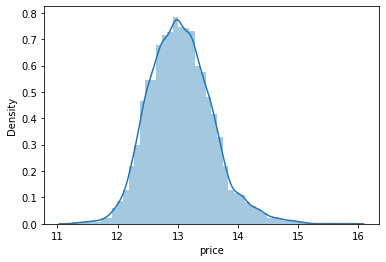

In [10]:
sns.distplot(y) # target log1p(y)값 분포도확인

In [12]:
# RMSE 계산
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [13]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
# 모델값 정의 및 리스트에 저장
random_state=32

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm]

In [16]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

    

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,142340.583522
XGBRegressor,127596.661792
LGBMRegressor,127164.204459


In [17]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

In [18]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=5)
    grid_model.fit(train,y)
    params=grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score']=score
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results=results.sort_values('RMSLE')
    
    return results

In [19]:
param_grid = { # gboost의 hyperparameters
    'n_estimators':[200,500],
    'max_depth' :[6,10],
    'learning_rate':[0.1,0.2]
}
model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model,train,y,param_grid, verbose=2,n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  8.6min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.1,6,500,-0.027079,0.164556
0,0.1,6,200,-0.027101,0.164625
4,0.2,6,200,-0.028212,0.167963
5,0.2,6,500,-0.028838,0.169817
2,0.1,10,200,-0.029517,0.171806
3,0.1,10,500,-0.029570,0.171960
6,0.2,10,200,-0.031191,0.176610
7,0.2,10,500,-0.031209,0.176662


- gboost모델에서 best parameter는 ```learning_rate=0.1```, ```max_depth=6```, ```n_estimators = 500```이다.

In [21]:
param_grid = { # xgboost의 hyperparameters
    'n_estimators':[200],
    'max_depth' :[10,12],
    'learning_rate':[0.1,0.2]
}
model = XGBRegressor(random_state=random_state)
my_GridSearch(model,train,y,param_grid, verbose=2,n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed: 29.2min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,10,200,-0.026859,0.163887
1,0.1,12,200,-0.027582,0.166079
2,0.2,10,200,-0.028723,0.169480
3,0.2,12,200,-0.029186,0.170838


- xgboost는 시간이 많이 걸려 n_estimator도 200으로 주었다.
- 원래는 100,200,500을 줬는데, 시간이 너무 많이 걸려서 200으로 주었다.
- xgboost모델에서 best parameter는  ```learning_rate=0.1```, ```max_depth=10```, ```n_estimators =200```이다.

In [22]:
param_grid = { # lightgbm의 hyperparameters
    'n_estimators':[200,500],
    'max_depth' :[10,12,14],
    'learning_rate':[0.1,0.2]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model,train,y,param_grid, verbose=2,n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   31.0s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,10,200,-0.026188,0.161828
1,0.1,10,500,-0.026245,0.162004
3,0.1,12,500,-0.026311,0.162207
2,0.1,12,200,-0.026322,0.162239
4,0.1,14,200,-0.026333,0.162276
5,0.1,14,500,-0.026453,0.162644
8,0.2,12,200,-0.027271,0.165138
10,0.2,14,200,-0.027332,0.165324
6,0.2,10,200,-0.027432,0.165625
11,0.2,14,500,-0.028021,0.167395


- lightgbm 모델에서 best parameter는  ```learning_rate=0.1```, ```max_depth=10```, ```n_estimators =200```이다.

In [27]:
# sample_submission
def save_submission(model,train,y,test,model_name, rmsle=None):
    model.fit(train,y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv("HOME")+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [25]:
model = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, n_estimators = 500, random_state=random_state)

In [28]:
save_submission(model, train, y, test, 'gboost', rmsle='0.1645')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gboost_RMSLE_0.1645.csv saved!


In [29]:
model = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators = 200, random_state=random_state)

In [30]:
save_submission(model, train, y, test, 'xgboost', rmsle='0.1638')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgboost_RMSLE_0.1638.csv saved!


In [31]:
model = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators = 200, random_state=random_state)

In [32]:
save_submission(model, train, y, test, 'lightgbm', rmsle='0.1618')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lightgbm_RMSLE_0.1618.csv saved!


각각의 모델들은 Private score기준으로 11만점 아래로 내려가지는 않았다.
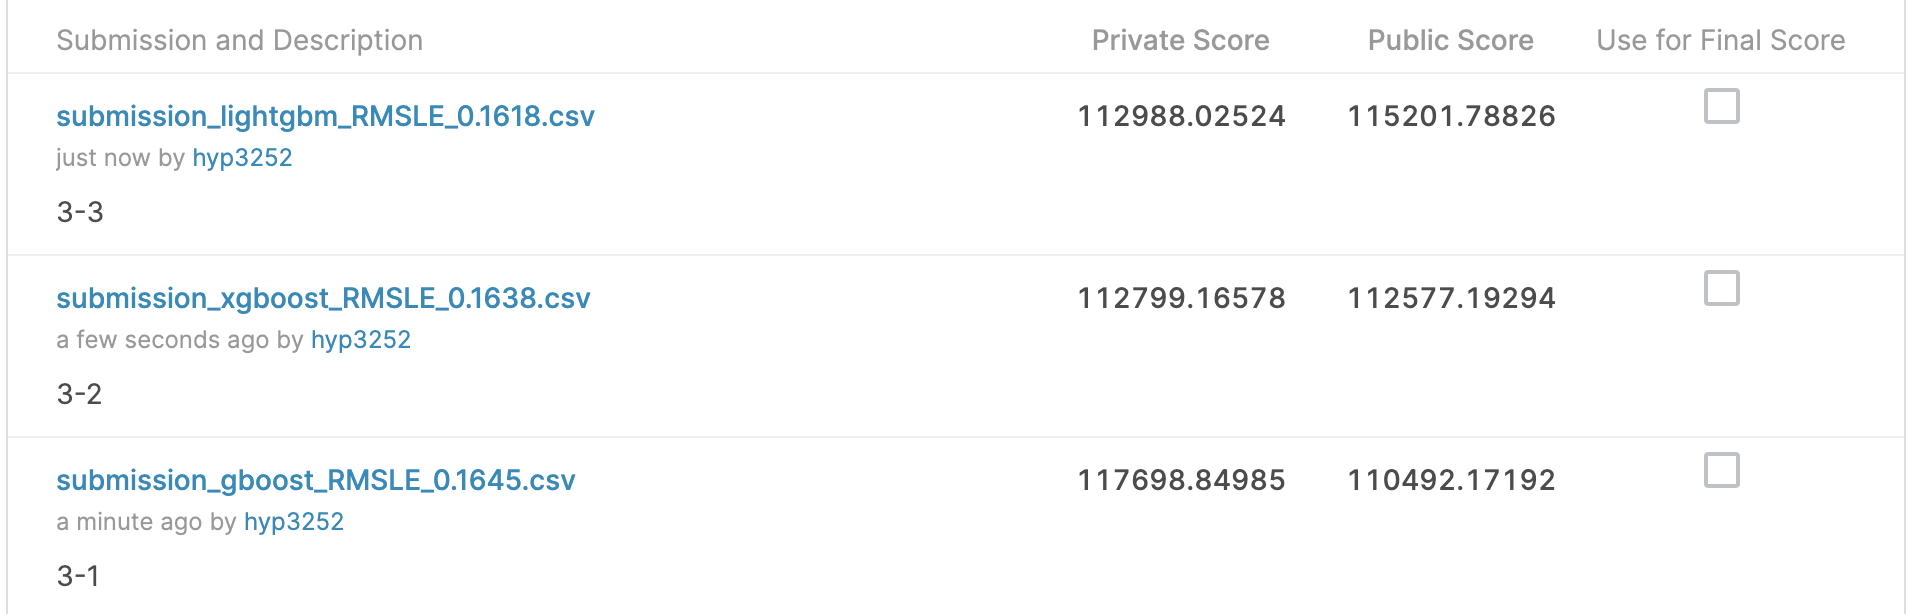

그래서 최적의 파라미터 결과를 더하여 더 나은 결과 도출을 위해 Average Blending을 진행하였다.

# Average Blending을 위한 준비

In [290]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')
print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [291]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [292]:
y = data['price']
del data['price']

In [293]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [294]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [295]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [296]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))


In [297]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [298]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [299]:
random_state=32
gboost = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, n_estimators = 1000, random_state=random_state)
xgboost = XGBRegressor(random_state=random_state, n_estimators=500)
lightgbm = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators = 200, random_state=random_state, num_leaves=31,min_data_in_leaf=10)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


In [300]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.8968
Model: XGBoost, CV score:0.8857
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since yo

In [301]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [302]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6468


array([ 507717.6860299 ,  500568.53853304, 1441697.70412602, ...,
        477510.30309557,  340795.94146227,  444626.90431823])

In [303]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [304]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

In [305]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


## 고찰
- 많은 시간을 투자했지만 11만점 아래로 내리는데에는 실패했다.
- cvscore가 xgboost에서는 하이퍼파라미터를 default로 놓는게 가장 점수가 높았고,
- ligtgbm 모델은 보통 num_leaves = 2^(max_depth)는 depth-wise tree와 같은 수의 leaves를 가지게 하여, 이보다 작게 설정해야 오버피팅을 줄일 수 있다.(default=31), 512로 주었을 때 lightgbm cv score:0.8823, 31로주었을때 0.8821, 21 로 주었을때 0.8848, 11일때 0.8857
- gboost에서 하이퍼파라미터 n_estimator=1000을 추가했더니 cv score가 약 0.3정도올랐지만 private score의 변화는 별로 없었다.

## 결론
- 앙상블로는 성능을 확실히 끌어올리지 못하였다.
- 시간이 많이 걸려서 하이퍼파라미터를 조정하는데에 애를 먹었다.

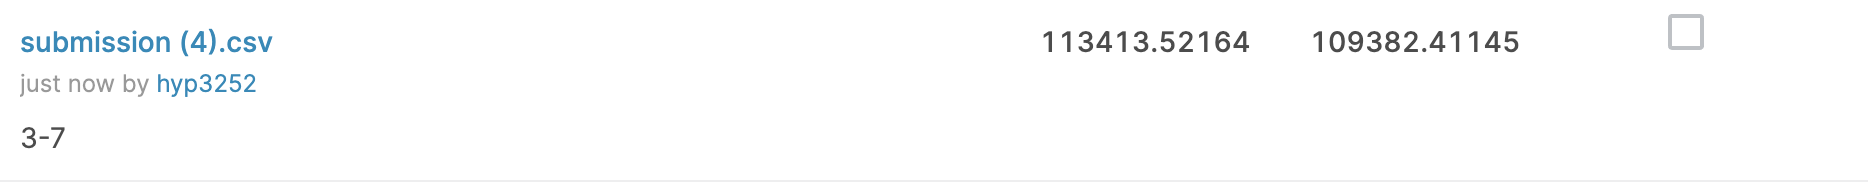
- public score는 10만대가 나왔지만 private은 113,413

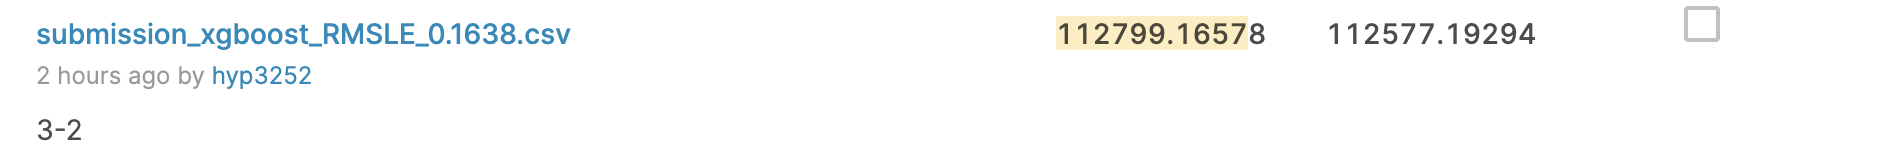
- public score가 112,577 인데 비해 private score는 112,799

xgboost 모델에서는

오히려 앙상블한 모델보다 private score는 낮게 나오는 상황이 발생하였다.